In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tskit
import tszip
import pickle
from matplotlib import font_manager

font_dirs = ["/home/hblee/.conda/envs/tskit_dev/fonts"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    try:
        font_manager.fontManager.addfont(font_file)
    except:
        pass
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['arial']
plt.rcParams["mathtext.fontset"] = 'cm'

In [2]:
prefix = "/home/hblee/research/tslmm_archive/tslmm_paper/05-pedigree/"
ts = tszip.decompress(prefix + "arg/spatial-simulation.0.genealogies.trees")
sample_locations = np.array([
            [ind.metadata["location_x"], ind.metadata["location_y"]]
            for ind in ts.individuals() if
            np.bitwise_and(ts.nodes_flags[ind.nodes[0]], tskit.NODE_IS_SAMPLE)
        ])
phenotypes = pickle.load(open(prefix + "arg/spatial-simulation.0.phenotypes.pkl", "rb"))
sample_phenotypes = phenotypes.phenotype.phenotype

In [3]:
samples, = np.where(ts.individuals_time == 0)
tables = ts.dump_tables()
ind_tables = tables.individuals
ind_tables.replace_with(ind_tables[samples])
ind_tables.parents = np.full(2 * len(samples), -1, dtype=np.int32)

node_tables = tables.nodes
nodes_individual = node_tables.individual
nodes_historic, = np.where(nodes_individual >= len(samples))
nodes_individual[nodes_historic] = -1
node_tables.individual = nodes_individual

_ts = tables.tree_sequence()
ts = _ts.simplify(_ts.individuals_nodes.ravel())

In [6]:
prefix = "/home/hblee/research/tslmm_archive/tslmm_paper/05-pedigree/"
held_out = np.arange(1, 13307, 2)
tblups = [np.load(prefix + f"true/spatial-simulation.{i}.blup.npy")[held_out] for i in range(20)]
iblups = [np.load(prefix + f"infer/spatial-simulation.{i}.blup.npy")[held_out] for i in range(20)]
pblups = [np.loadtxt(prefix + f"pedigree/spatial-simulation.{i}.blup.txt")[::-1] for i in range(20)]
rblups = [np.load(prefix + f"rhe/spatial-simulation.{i}.blup.npy")[held_out] for i in range(20)]

sblups110 = [np.loadtxt(prefix + f"site/spatial-simulation.{i}.1e-10.blup.txt") for i in range(20)]
sblups109 = [np.loadtxt(prefix + f"site/spatial-simulation.{i}.1e-09.blup.txt") for i in range(20)]
sblups108 = [np.loadtxt(prefix + f"site/spatial-simulation.{i}.1e-08.blup.txt") for i in range(20)]

gvals = [np.loadtxt(prefix + f"pedigree/spatial-simulation.{i}.phenotypes.txt")[::-1][held_out] for i in range(20)]
ctblups = [np.corrcoef(x,y)[0,1] for x,y in zip(tblups,gvals)]
cpblups = [np.corrcoef(x,y)[0,1] for x,y in zip(pblups,gvals)]
ciblups = [np.corrcoef(x,y)[0,1] for x,y in zip(iblups,gvals)]
crblups = [np.corrcoef(x,y)[0,1] for x,y in zip(rblups,gvals)]

csblups110 = [np.corrcoef(x,y)[0,1] for x,y in zip(sblups110,gvals)]
csblups109 = [np.corrcoef(x,y)[0,1] for x,y in zip(sblups109,gvals)]
csblups108 = [np.corrcoef(x,y)[0,1] for x,y in zip(sblups108,gvals)]

arr = np.vstack(
    [ctblups, ciblups, crblups,
     csblups108, csblups109, csblups110,
     cpblups]
).T

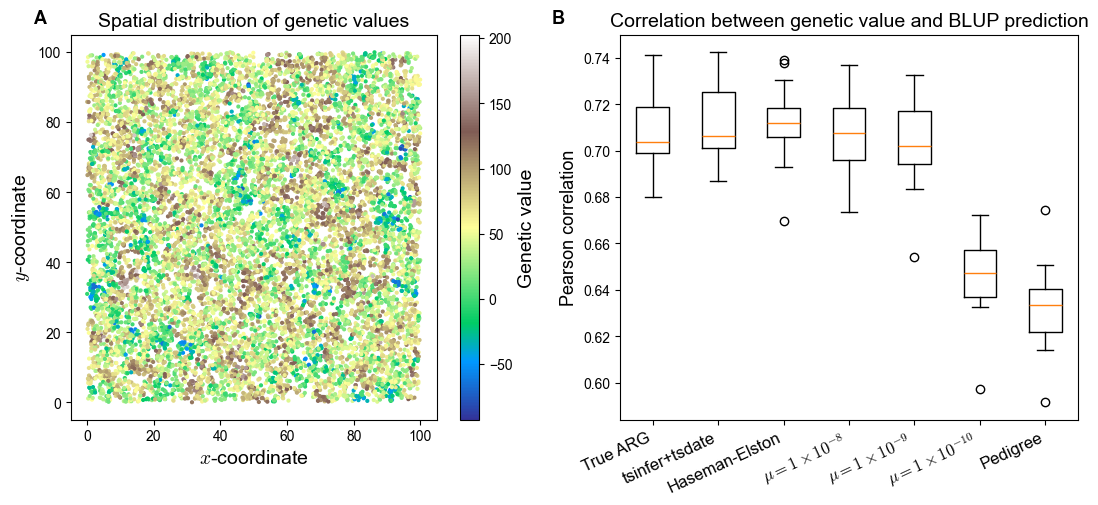

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))

# first plot
img = ax[0].scatter(
    sample_locations[:,0],
    sample_locations[:,1],
    s=4,
    c=sample_phenotypes[ts.individuals_time==0],
    cmap="terrain",
    rasterized=True,
)
ax[0].set_title('Spatial distribution of genetic values', fontsize=14)
ax[0].set_xlabel(r"$x$-coordinate", fontsize=14)
ax[0].set_ylabel(r"$y$-coordinate", fontsize=14)
cbar = fig.colorbar(img, ax=ax[0])
cbar.set_label("Genetic value", fontsize=14)
ax[0].text(-0.1, 1.03, 'A', fontweight='bold', fontsize=13, transform=ax[0].transAxes)

# second plot
ax[1].boxplot(arr)
ax[1].set_xticklabels(
    [
        'True ARG', 
        'tsinfer+tsdate', 
        'Haseman-Elston',
        r'$\mu=1 \times 10^{-8}$', 
        r'$\mu=1 \times 10^{-9}$',
        r'$\mu=1 \times 10^{-10}$',
        
        #r'$\mu=2 \times 10^{-9}$',
        #r'$\mu=5 \times 10^{-9}$', 
        
        #r'$\mu=2 \times 10^{-8}$', 
        #r'$\mu=5 \times 10^{-8}$', 
        'Pedigree'
    ], fontsize=12, rotation=25, ha="right")
ax[1].set_title('Correlation between genetic value and BLUP prediction', fontsize=14)
ax[1].set_ylabel('Pearson correlation', fontsize=13)
ax[1].text(-0.15, 1.03, 'B', fontweight='bold', fontsize=13, transform=ax[1].transAxes)

#ax[1].set_ylim([0.73, 0.85])


plt.savefig("pedigree.pdf", bbox_inches="tight")
plt.show()

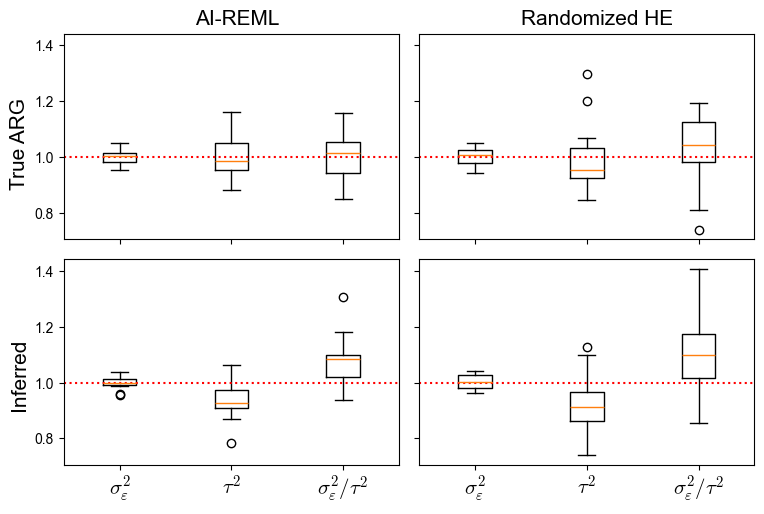

In [5]:
vc_true = [np.load(prefix + f"true/spatial-simulation.{i}.vc.npy") for i in range(20)]
vc_infer = [np.load(prefix + f"infer/spatial-simulation.{i}.vc.npy") for i in range(20)]

fig, ax = plt.subplots(2, 2, figsize=(7.5,5), sharex=True, sharey=True)

# REML - True
arr_p = np.vstack([vc[0] for vc in vc_true])
arr = np.zeros((arr_p.shape[0],3))
arr[:,:2] = arr_p
arr[:,2] = arr[:,0] / arr[:,1]
ax[0,0].boxplot(arr)
ax[0,0].axhline(1, color='red', ls=":")

# HE - True
arr_p = np.vstack([vc[1] for vc in vc_true])
arr = np.zeros((arr_p.shape[0],3))
arr[:,:2] = arr_p
arr[:,2] = arr[:,0] / arr[:,1]
ax[0,1].boxplot(arr)
ax[0,1].axhline(1, color='red', ls=":")

# REML - True
arr_p = np.vstack([vc[0] for vc in vc_infer])
arr = np.zeros((arr_p.shape[0],3))
arr[:,:2] = arr_p
arr[:,2] = arr[:,0] / arr[:,1]
ax[1,0].boxplot(arr)
ax[1,0].axhline(1, color='red', ls=":")

# HE - True
arr_p = np.vstack([vc[1] for vc in vc_infer])
arr = np.zeros((arr_p.shape[0],3))
arr[:,:2] = arr_p
arr[:,2] = arr[:,0] / arr[:,1]
ax[1,1].boxplot(arr)
ax[1,1].axhline(1, color='red', ls=":")

for i in range(2):
    for j in range(2):
        ax[i,j].set_xticks([1,2,3])
        ax[i,j].set_xticklabels([r"$\sigma_\varepsilon^2$", r"$\tau^2$", r"$\sigma^2_\varepsilon/\tau^2$"], fontsize=15)

# Labels
fig.text(0, 0.75, "True ARG", rotation=90, fontsize=15, ha="center", va="center")
fig.text(0, 0.29, "Inferred", rotation=90, fontsize=15, ha="center", va="center")
fig.text(0.29, 1, "AI-REML", rotation=0, fontsize=15, ha="center", va="center")
fig.text(0.77, 1, "Randomized HE", rotation=0, fontsize=15, ha="center", va="center")

plt.tight_layout()
plt.savefig("spatial-estimation.pdf", bbox_inches="tight")
plt.show()

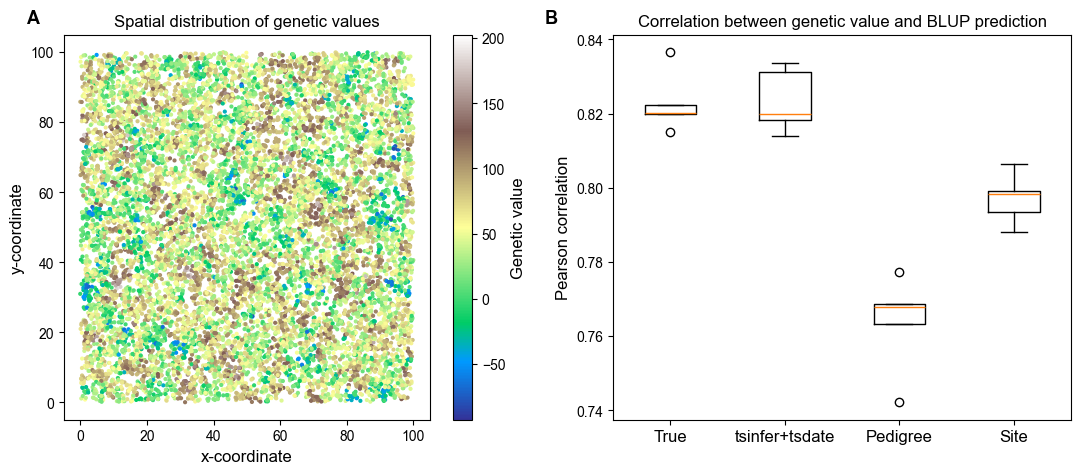

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))

# first plot
img = ax[0].scatter(
    sample_locations[:,0],
    sample_locations[:,1],
    s=4,
    c=sample_phenotypes[ts.individuals_time==0],
    cmap="terrain",
)
ax[0].set_title('Spatial distribution of genetic values', fontsize=12)
ax[0].set_xlabel("x-coordinate", fontsize=12)
ax[0].set_ylabel("y-coordinate", fontsize=12)
cbar = fig.colorbar(img, ax=ax[0])
cbar.set_label("Genetic value", fontsize=12)
ax[0].text(-0.1, 1.03, 'A', fontweight='bold', fontsize=13, transform=ax[0].transAxes)

# second plot
ax[1].boxplot(arr)
ax[1].set_xticklabels(['True', 'tsinfer+tsdate', 'Pedigree', 'Site'], fontsize=12)
ax[1].set_title('Correlation between genetic value and BLUP prediction')
ax[1].set_ylabel('Pearson correlation', fontsize=12)
ax[1].text(-0.15, 1.03, 'B', fontweight='bold', fontsize=13, transform=ax[1].transAxes)


plt.savefig("pedigree.eps", bbox_inches="tight")
plt.show()